# Phase 3: Ekstraksi Fitur Konten & Perilaku

**Tujuan:** Pada tahap ini, kita akan melampaui analisis struktur jaringan dan mulai "membaca" konten serta menganalisis pola perilaku. Tujuannya adalah untuk mengkuantifikasi dua sinyal buzzer yang paling kuat:
1.  **Narasi yang Seragam:** Buzzer sering kali menyebarkan pesan yang sama atau sangat mirip (copy-paste). Kita akan mengukur ini dengan **Skor Kesamaan Narasi**.
2.  **Aktivitas Anomali:** Akun buzzer sering memiliki pola aktivitas yang tidak wajar. Kita akan membuat fitur untuk menangkap sinyal ini.

**Langkah-langkah yang akan dilakukan:**
1.  **Load & Merge Data:** Memuat data dari Phase 1 (`master_dataset_cleaned.csv`) dan Phase 2 (`network_features.csv`) lalu menggabungkannya.
2.  **Calculate Narrative Similarity Score:** Menggunakan **TF-IDF** dan **Cosine Similarity** untuk menghitung seberapa mirip konten seorang pengguna dengan narasi rata-rata di dalam komunitasnya.
3.  **Engineer Behavioral Features:** Membuat fitur turunan dari metadata, seperti frekuensi tweet dan rasio reply.
4.  **Create Final Feature DataFrame:** Menggabungkan semua fitur (SNA, Konten, Perilaku) menjadi satu dataset akhir yang siap untuk pemodelan di Phase 4.

### 3.1. Install & Import Requirements for Feature Engineering

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

### 3.2. Load and Merge Datasets from Previous Phases

Kita membutuhkan informasi dari kedua tahap sebelumnya:
- `master_dataset_cleaned.csv`: Mengandung `username` dan `cleaned_text`.
- `network_features.csv`: Mengandung `username`, metrik SNA, dan label `community`.

Kita akan menggabungkan keduanya menjadi satu DataFrame komprehensif.


In [2]:
try:
    df_main = pd.read_csv('master_dataset_cleaned.csv')
    df_network = pd.read_csv('network_features.csv')
    print("✅ Dataset dari Phase 1 dan Phase 2 berhasil dimuat.")

    # Menggabungkan kedua DataFrame berdasarkan 'username'
    # 'inner' join memastikan kita hanya menganalisis akun yang ada di dalam jaringan
    df_features = pd.merge(df_network, df_main, on='username', how='inner')

    print(f"Shape setelah merge: {df_features.shape}")
    print("DataFrame gabungan siap untuk rekayasa fitur.")
    
except FileNotFoundError as e:
    print(f"❌ ERROR: File tidak ditemukan -> {e.filename}")
    print("Pastikan Anda sudah menjalankan notebook Phase 1 dan 2 terlebih dahulu.")
    df_features = pd.DataFrame()

✅ Dataset dari Phase 1 dan Phase 2 berhasil dimuat.
Shape setelah merge: (175, 12)
DataFrame gabungan siap untuk rekayasa fitur.


### 3.3. Calculate Narrative Similarity Score

Ini adalah langkah paling penting di tahap ini. Tujuannya adalah memberikan skor numerik pada setiap akun yang merepresentasikan seberapa mirip narasinya dengan narasi umum di dalam komunitasnya.

**Prosesnya:**
1.  Untuk setiap komunitas, kumpulkan semua teks dari anggotanya.
2.  Gunakan **TF-IDF** untuk mengubah teks tersebut menjadi vektor angka.
3.  Hitung **vektor rata-rata (centroid)** untuk setiap komunitas. Ini merepresentasikan "narasi utama" komunitas tersebut.
4.  Hitung **Cosine Similarity** antara vektor setiap akun dengan vektor centroid komunitasnya. Hasilnya adalah skor antara 0 (sangat beda) dan 1 (sangat mirip).


In [3]:
if not df_features.empty:
    # Inisialisasi kolom baru untuk skor similaritas
    df_features['narrative_similarity'] = 0.0
    
    # Mengelompokkan berdasarkan komunitas
    grouped_by_community = df_features.groupby('community')
    
    print("--- 3.3. Calculating Narrative Similarity... ---")
    
    # Loop melalui setiap komunitas
    for community_id, group in grouped_by_community:
        # Hanya proses komunitas dengan lebih dari 1 anggota
        if len(group) > 1:
            # Membersihkan teks dari nilai NaN potensial
            corpus = group['cleaned_text'].fillna('').tolist()
            
            # Inisialisasi dan fit TF-IDF Vectorizer
            vectorizer = TfidfVectorizer(stop_words=['yang', 'di', 'ini', 'itu', 'dan', 'dengan'])
            tfidf_matrix = vectorizer.fit_transform(corpus)
            
            # Hitung centroid (vektor rata-rata) dan konversi ke numpy array
            centroid = np.asarray(tfidf_matrix.mean(axis=0))
            
            # Hitung cosine similarity antara setiap dokumen dengan centroid
            similarity_scores = cosine_similarity(tfidf_matrix, centroid)
            
            # Masukkan skor kembali ke DataFrame utama
            df_features.loc[group.index, 'narrative_similarity'] = similarity_scores

    print("✅ Narrative similarity scores calculated successfully.")
    display(df_features[['username', 'community', 'narrative_similarity']].sort_values('narrative_similarity', ascending=False).head(10))


--- 3.3. Calculating Narrative Similarity... ---
✅ Narrative similarity scores calculated successfully.


,username,community,narrative_similarity
101,azwarlnst_,38,0.876543
100,azwarlnst_,38,0.876543
51,arasyaziz,22,0.747901
52,neohistoria_id,22,0.747901
42,bg_mush,17,0.743637
43,idextratime,17,0.743637
113,thelastgoodbtch,45,0.741249
114,thelastgoodbtch,45,0.741249
48,guesswho1333,20,0.730260
49,hrdbacot,20,0.730260


### 3.4. Engineer Behavioral Features

Selain konten, kita perlu mengukur pola perilaku. Kita akan membuat dua fitur sederhana namun kuat:

- **`tweet_frequency`**: Jumlah total tweet oleh seorang pengguna dalam dataset kita. Ini mengukur tingkat aktivitas mereka pada topik yang dianalisis.
- **`reply_ratio`**: Rasio tweet yang merupakan balasan. Akun yang hanya fokus menyebar narasi (bukan berdiskusi) cenderung memiliki rasio reply yang tinggi.

**Catatan:** Kita tidak bisa menghitung "umur akun" karena data user `created_at` tidak ada di dataset ini. Fitur `tweet_frequency` adalah proksi yang baik untuk aktivitas.


In [4]:
if not df_features.empty:
    # 1. Hitung frekuensi tweet per pengguna
    tweet_counts = df_main['username'].value_counts().reset_index()
    tweet_counts.columns = ['username', 'tweet_frequency']

    # 2. Gabungkan fitur frekuensi ke df_features
    df_features = pd.merge(df_features, tweet_counts, on='username', how='left')

    # 3. Hitung rasio reply
    # out_degree adalah jumlah balasan yang dibuat (dari Phase 2)
    # Hindari pembagian dengan nol
    df_features['reply_ratio'] = (df_features['out_degree'] / df_features['tweet_frequency']).fillna(0)

    print("--- 3.4. Behavioral Features Engineered ---")
    print("Fitur 'tweet_frequency' dan 'reply_ratio' berhasil dibuat.")
    display(df_features[['username', 'tweet_frequency', 'out_degree', 'reply_ratio']].head())


--- 3.4. Behavioral Features Engineered ---
Fitur 'tweet_frequency' dan 'reply_ratio' berhasil dibuat.


,username,tweet_frequency,out_degree,reply_ratio
0,JAditya36003,1,1,1.0
1,hoammss,1,1,1.0
2,marsusuka,1,1,1.0
3,Metro_TV,9,0,0.0
4,Metro_TV,9,0,0.0


### 3.5. Final Feature Set and Visualization

Sekarang kita gabungkan semua fitur yang telah dibuat (SNA, Konten, Perilaku) dan melihat hasilnya.



--- ✅ PHASE 3 COMPLETED ---
Output: DataFrame final dengan semua fitur (SNA, Konten, Perilaku).


,username,community,pagerank,betweenness,in_degree,out_degree,narrative_similarity,tweet_frequency,reply_ratio
0,JAditya36003,28,0.004140,0.0,0,1,0.209767,1,1.0
1,hoammss,28,0.004140,0.0,0,1,0.206077,1,1.0
2,marsusuka,1,0.004140,0.0,0,1,0.301069,1,1.0
3,Metro_TV,1,0.007659,0.0,1,0,0.443963,9,0.0
4,ml_sjyesung2,2,0.004140,0.0,0,1,0.572539,1,1.0
5,barengwarga,2,0.011178,0.0,2,0,0.587033,1,0.0
6,Bagoesaporla16,3,0.004140,0.0,0,1,0.000000,1,1.0
7,monkmalonee,4,0.004140,0.0,0,1,0.000000,1,1.0
8,Juliakango,5,0.004140,0.0,0,1,0.000000,1,1.0
9,nalllinaa,6,0.004140,0.0,0,1,0.707107,2,0.5



✅ Fitur gabungan berhasil disimpan ke 'final_features.csv'


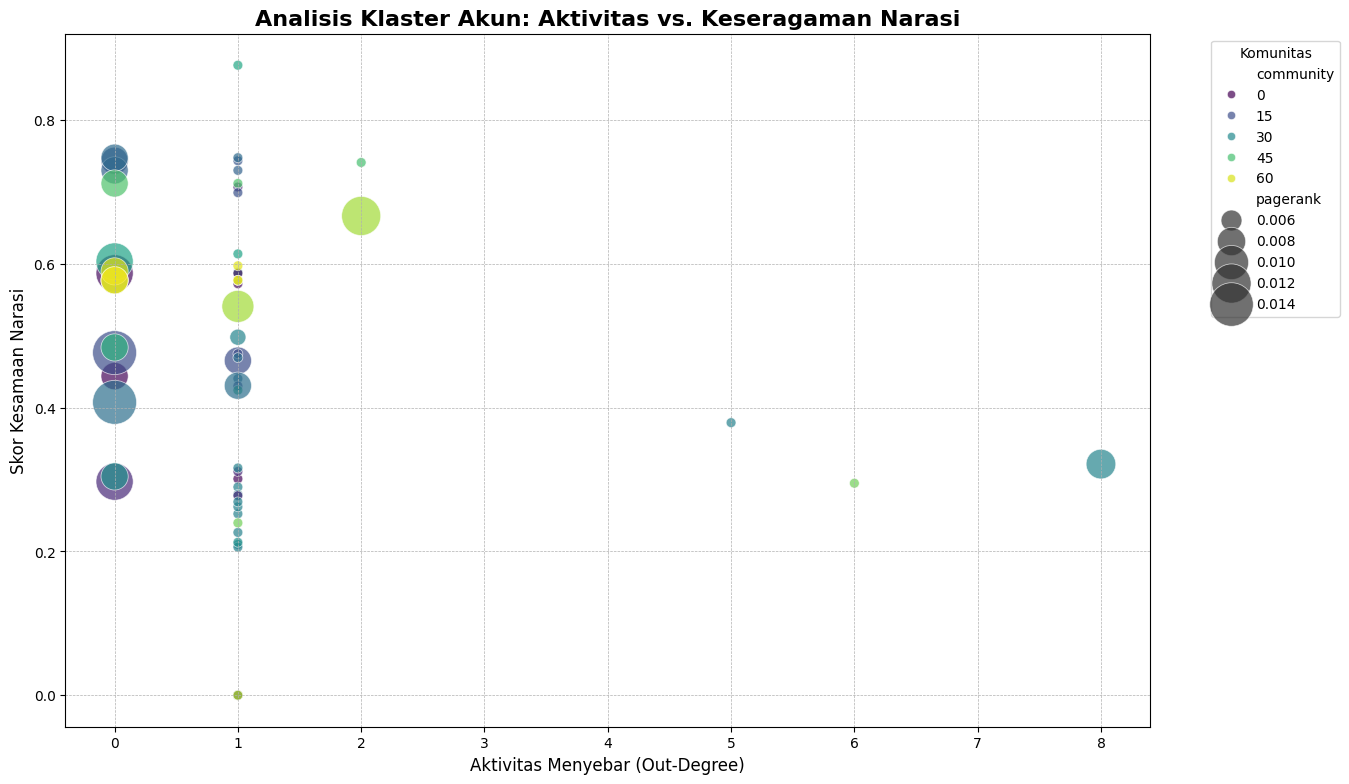

In [5]:
if not df_features.empty:
    # Memilih kolom-kolom fitur yang relevan untuk model
    final_feature_columns = [
        'username', 'community',
        'pagerank', 'betweenness', 'in_degree', 'out_degree', # Fitur SNA
        'narrative_similarity', # Fitur Konten
        'tweet_frequency', 'reply_ratio' # Fitur Perilaku
    ]
    df_final_features = df_features[final_feature_columns].drop_duplicates(subset=['username']).reset_index(drop=True)

    print("\n--- ✅ PHASE 3 COMPLETED ---")
    print("Output: DataFrame final dengan semua fitur (SNA, Konten, Perilaku).")
    display(df_final_features.head(10))

    # Menyimpan hasil ke file CSV untuk digunakan di Phase 4
    df_final_features.to_csv('final_features.csv', index=False)
    print("\n✅ Fitur gabungan berhasil disimpan ke 'final_features.csv'")

    # Visualisasi: Hubungan antara Aktivitas Menyebar (Out-Degree) dan Keseragaman Narasi
    plt.figure(figsize=(14, 9))
    sns.scatterplot(
        data=df_final_features,
        x='out_degree',
        y='narrative_similarity',
        hue='community',
        size='pagerank',
        sizes=(50, 1000),
        palette='viridis',
        alpha=0.7
    )
    plt.title('Analisis Klaster Akun: Aktivitas vs. Keseragaman Narasi', fontsize=16, fontweight='bold')
    plt.xlabel('Aktivitas Menyebar (Out-Degree)', fontsize=12)
    plt.ylabel('Skor Kesamaan Narasi', fontsize=12)
    plt.legend(title='Komunitas', bbox_to_anchor=(1.05, 1), loc=2)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

else:
    print("\n--- ❌ PHASE 3 FAILED ---")
    print("DataFrame fitur kosong, tidak ada yang bisa diproses.")
